## **Dataset preparation**
- Downloading dataset
- Dataset analysis
- Preprocessing
- Text tokenization
- Structure dataset

In [1]:
'''
Downloading dataset
'''
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


In [2]:
'''
Dataset analysis
'''
import pandas as pd

def pd_info(pd):
    for i in pd.columns:
        print(f'{i} {pd[i].nunique()} values, nan {pd[i].isnull().sum(axis=0)}, type {pd[i].dtypes}')
        if pd[i].nunique()<5:
            print(pd[i].value_counts())
    print('other information')
    print(pd.info())
#     print(pd.describe())
df_train = pd.read_csv('dataset/train_pairs.csv', sep = ',').drop(['Unnamed: 0', 'ID'], axis = 1)
df_val = pd.read_csv('dataset/val_pairs.csv', sep = ',').drop(['Unnamed: 0', 'ID'], axis = 1)
df_test = pd.read_csv('dataset/test_pairs.csv', sep = ',').drop(['Unnamed: 0', 'ID'], axis = 1)

pd_info(df_train)
pd_info(df_val)
pd_info(df_test)
df_train.head(5)

Claim 101632 values, nan 0, type object
Evidence 16991 values, nan 0, type object
Label 2 values, nan 0, type object
SUPPORTS    89389
REFUTES     32351
Name: Label, dtype: int64
other information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121740 entries, 0 to 121739
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Claim     121740 non-null  object
 1   Evidence  121740 non-null  object
 2   Label     121740 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB
None
Claim 6458 values, nan 0, type object
Evidence 1596 values, nan 0, type object
Label 2 values, nan 0, type object
SUPPORTS    3611
REFUTES     3554
Name: Label, dtype: int64
other information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Claim     7165 non-null   object
 1   Evidence  7165 non-null   object
 2 

,Claim,Evidence,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,REFUTES


In [3]:
'''
Preprocessing: remove some pronunciations and symbols
'''
import re
from functools import reduce
import nltk
from typing import List, Callable
 
re_remove_number= re.compile('([0-9]\\t|[0-9])')
replace_symbols = re.compile('[/(){}\[\]\|@,;]')
good_symbols = re.compile('[^0-9a-z #+_]')
 
def remove_leading_tabs(text: str) -> str:
    pattern = r'[0-9]+?\t'
    return re.sub(pattern, '', text)
 
def remove_pronunciations(text: str) -> str:
    pattern = r'-LSB-.*?-RSB-(\s;)*?'
    return re.sub(pattern, '', text)
 
def remove_brackets(text: str) -> str:
    pattern = re.compile('(\-RSB\-|\-RRB\-|\-LSB\-|\-LRB\-)')
    return re.sub(pattern, '', text)
 
def fix_double_dashes(text: str) -> str:
    pattern = r'\-\-'
    return re.sub(pattern, '-', text)
 
def remove_trailing_words(text) :
    pattern = r'.\t.*?$'
    return re.sub(pattern, '.', text)
 
def split_genitive(text: str) -> str:
    pattern = r"(\s.+?)'s"
    return re.sub(pattern, r"\1's", text)
 
def separate_non_words(text) :
    pattern = r'([a-zA-Z]+?)\-([a-zA-Z]+?)'
    return re.sub(pattern, r'\1 - \2', text)
 
def lower(text: str) -> str:
    return text.lower()
 
def remove_initial_no(str:str) -> str:
    return re.sub(re_remove_number,"",str)
 
def replace_special_characters(text: str) -> str:
    return replace_symbols.sub(' ', text)
 
def replace_br(text: str) -> str:
    return text.replace('br', '')
 
def filter_out_uncommon_symbols(text: str) -> str:
    return re.sub(good_symbols, '',text)
 
def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in stopwords_set])
 
def strip_text(text: str) -> str:
    return text.strip()
 
def remove_langpron(text: str)-> str:
    return text.replace('langpron',"")
 
def remove_dl(text:str)-> str:
    pattern = re.compile('( dl | ul )')
    return re.sub(pattern, '', text)

def data_preprocessing(df):
    print(f'input {df.head(5)}')
    
    
preprocessing = [remove_leading_tabs, remove_pronunciations, remove_brackets,
           fix_double_dashes, remove_trailing_words, split_genitive,
           separate_non_words,
           lower, remove_initial_no, replace_special_characters,
           replace_br, filter_out_uncommon_symbols,
           strip_text, remove_langpron]

def text_prepare(text, filter_methods=preprocessing):
    return reduce(lambda txt, f: f(txt), filter_methods, text)

def dataset_preprocessing(df):
    df['Evidence'] = df['Evidence'].apply(lambda txt: text_prepare(txt))
    df['Claim'] = df['Claim'].apply(lambda txt: text_prepare(txt))
    return df

for i in [df_train, df_val, df_test]:
    print(f'input: {i.iloc[:5,1]}')
    i = dataset_preprocessing(i)
    print('')
    print(f'after preprocessing: {i.iloc[:5,1]}')
    print('')
    print('')



input: 0    2\tHemsworth has also appeared in the science ...
1    0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
2    0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
3    10\tThe island 's geography comprises relative...
4    10\tThe island 's geography comprises relative...
Name: Evidence, dtype: object

after preprocessing: 0    hemsworth has also appeared in the science fic...
1    roald dahl         september    november   was...
2    roald dahl         september    november   was...
3    the island s geography comprises relatively lo...
4    the island s geography comprises relatively lo...
Name: Evidence, dtype: object


input: 0    16\tIt is an all-volunteer force and comprises...
1    6\tEminem also collaborated with artists such ...
2    6\tEminem also collaborated with artists such ...
3    8\tThe film was nominated in four categories a...
4    0\tVietnam -LRB- ˌ ; -LSB- vîət nāːm -RSB- -RR...
Name: Evidence, dtype: object

after preprocessing: 0    it is an all  volunt

In [4]:
df_train

,Claim,Evidence,Label
0,chris hemsworth appeared in a perfect getaway,hemsworth has also appeared in the science fic...,SUPPORTS
1,roald dahl is a writer,roald dahl september november was...,SUPPORTS
2,roald dahl is a governor,roald dahl september november was...,REFUTES
3,ireland has relatively low lying mountains,the island s geography comprises relatively lo...,SUPPORTS
4,ireland does not have relatively low lying mo...,the island s geography comprises relatively lo...,REFUTES
...,...,...,...
121735,april was the month anderson silva was born,anderson da silva born april is a azi...,SUPPORTS
121736,anderson silva is an american azilian mixed ma...,anderson da silva born april is a azi...,REFUTES
121737,anderson silva is incapable of being a azilian...,anderson da silva born april is a azi...,REFUTES
121738,anderson silva was born on the month of april th,anderson da silva born april is a azi...,SUPPORTS


In [5]:
'''
Text tokenization & Embedding
Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the words and punctuation in a string. 
Reference: https://www.nltk.org/api/nltk.tokenize.html
'''

from nltk.tokenize import wordpunct_tokenize
import gensim
import gensim.downloader as gloader
import scipy
from collections import OrderedDict
from typing import OrderedDict
from tqdm import tqdm
import numpy as np
import gc

def tokenize_data(df):
    df['Evidence'] = df['Evidence'].apply(wordpunct_tokenize)
    df['Claim'] = df['Claim'].apply(wordpunct_tokenize)
    return df

def check_OOV_terms(embedding_model, word_listing):
    '''
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.
    '''

    embedding_vocabulary = set(embedding_model.key_to_index)
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

def build_embedding_matrix(embedding_model,
                           embedding_dimension,
                           word2idx,
                           idx2word):

    # Note: we take (vocab_size) + 1 since we start counting by 1, having reserved 0 for the padding.
    embedding_matrix = np.zeros((len(word2idx), embedding_dimension), dtype = np.float32) 

    for word, idx in tqdm(word2idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low = -0.05, high = 0.05, size = embedding_dimension)
        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

  
def build_vocabulary(corpus):

    word_listing = []
    for setence in corpus:
        for word in setence.split(' '):
            word_listing.append(word)
    words = set(word_listing)
    word2idx = {}
    idx2word = {}
    for i, word in tqdm(enumerate(words)):
        idx2word[i] = word
        word2idx[word] = i
        
    return idx2word, word2idx, word_listing



embedding_dimension = 50
print(f'loading embedding model from glove...')
embedding_model = gloader.load(f"glove-wiki-gigaword-{embedding_dimension}")

corpus = pd.concat([df_train['Claim'], df_train['Evidence'], df_val['Claim'], df_val['Evidence'], df_test['Claim'], df_test['Evidence']], ignore_index=True).values
idx_to_word, word_to_idx, word_listing = build_vocabulary(corpus)
oov_terms = check_OOV_terms(embedding_model, word_listing)

print(f"Total OOV terms: {len(oov_terms)} ({float(len(oov_terms)) / len(word_listing)*100}%)")

MAX_SENTENCE_LENGTH = max(len(x) for x in corpus)
print(f"Longest sentence: {MAX_SENTENCE_LENGTH} words")

del corpus
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, idx_to_word)
print("Embedding matrix shape: {}".format(embedding_matrix.shape))


loading embedding model from glove...
[==================================================] 100.0% 66.0/66.0MB downloaded


33954it [00:00, 1394705.69it/s]


Total OOV terms: 3559 (0.06358035465296899%)
Longest sentence: 767 words


100%|██████████| 33954/33954 [00:00<00:00, 308461.08it/s]

Embedding matrix shape: (33954, 50)


In [6]:
'''
Structure dataset
'''
from tensorflow.keras.preprocessing.sequence import pad_sequences

binary_map = {'REFUTES': 0, 'SUPPORTS': 1}
print(f"Longest sentence: {MAX_SENTENCE_LENGTH} words")
tokens = MAX_SENTENCE_LENGTH//7
def struct_dataframe(dataframe, word2idx):
    s_dataframe = pd.DataFrame(columns = ['Claim', 'Evidence', 'Label'])

    for columns in ['Claim', 'Evidence'] :
        s_dataframe[columns] = dataframe[columns].apply(lambda sentence: [word2idx[words] for words in sentence.split(' ')])
    s_dataframe['Label'] = dataframe['Label'].map(binary_map)

    return s_dataframe

def embed_sentence(embedding_matrix, sentence, word_to_idx):
    return [word2idx[words] for words in sentence]



train = struct_dataframe(df_train, word_to_idx)
train_claim = pad_sequences(train['Claim'], maxlen = tokens, padding = 'post')
train_evidence = pad_sequences(train['Evidence'], maxlen = tokens, padding = 'post')

val = struct_dataframe(df_val, word_to_idx)
val_claim = pad_sequences(val['Claim'], maxlen = tokens, padding = 'post')
val_evidence = pad_sequences(val['Evidence'], maxlen = tokens, padding = 'post')

test = struct_dataframe(df_test, word_to_idx)

test_claim = pad_sequences(test['Claim'], maxlen = tokens, padding = 'post')
test_evidence = pad_sequences(test['Evidence'], maxlen = tokens, padding = 'post')

Longest sentence: 767 words


In [7]:
train

,Claim,Evidence,Label
0,"[22858, 504, 2285, 17353, 3824, 30125, 19097]","[504, 13716, 10729, 2285, 17353, 4532, 27415, ...",1
1,"[22864, 33078, 13032, 3824, 23503]","[22864, 33078, 0, 0, 0, 0, 0, 0, 0, 0, 5696, 0...",1
2,"[22864, 33078, 13032, 3824, 24977]","[22864, 33078, 0, 0, 0, 0, 0, 0, 0, 0, 5696, 0...",0
3,"[24012, 13716, 2406, 16881, 0, 204, 4424]","[4532, 2236, 33572, 8143, 12078, 2406, 16881, ...",1
4,"[24012, 5668, 31929, 16972, 2406, 16881, 0, 20...","[4532, 2236, 33572, 8143, 12078, 2406, 16881, ...",0
...,...,...,...
121735,"[26023, 6397, 4532, 27113, 18964, 32831, 6397,...","[18964, 4931, 32831, 0, 0, 0, 0, 27659, 26023,...",1
121736,"[18964, 32831, 13032, 6289, 29148, 22374, 1413...","[18964, 4931, 32831, 0, 0, 0, 0, 27659, 26023,...",0
121737,"[18964, 32831, 13032, 8003, 16680, 4668, 3824,...","[18964, 4931, 32831, 0, 0, 0, 0, 27659, 26023,...",0
121738,"[18964, 32831, 6397, 27659, 21465, 4532, 27113...","[18964, 4931, 32831, 0, 0, 0, 0, 27659, 26023,...",1


## Building network and training
   - building network
   - training network

In [8]:
embedding_matrix.shape,MAX_SENTENCE_LENGTH

((33954, 50), 767)

In [9]:
'''
Building network
- LSTM_network
- MLP_network
'''
from tensorflow.keras.layers import SimpleRNN, LSTM,Bidirectional, Dense, TimeDistributed, Input, Reshape, Embedding, concatenate, add, average, Average, Dropout, dot, maximum,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant, glorot_normal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy 
import tensorflow as tf
emb_dim = 50

def lstm_network(max_tokens: int, embedding_dimension: int, embedding_matrix: np.ndarray, merge_strategy: str,  cos_similarity: bool, 
                 dropout: float = 0.40, recurrent_dropout: float = 0.25, initial_learning_rate: float = 0.0001):
    '''
    Define LSTM model
    '''
    hidden_nodes = emb_dim
    claim_input = Input(shape = (max_tokens, ), name = 'claim_input')
    evidence_input = Input(shape = (max_tokens, ), name = 'evidence_input')
    shared_embedding = Embedding(input_dim = embedding_matrix.shape[0],
                               output_dim = embedding_dimension,
                               mask_zero = True,
                               embeddings_initializer = Constant(embedding_matrix),
                               trainable = False,
                               name = 'embedding_layer')
    bs1 = BatchNormalization()
    embedded_claim = bs1(shared_embedding(claim_input))
    embedded_evidence = bs1(shared_embedding(evidence_input))

    shared_rnn = Bidirectional(LSTM(hidden_nodes,
                                         return_sequences = True, return_state = False,
                                         dropout = dropout, recurrent_dropout = recurrent_dropout, 
                                         name = 'rnn_layer_claim'))
    
    bs2 = BatchNormalization()

    rnn_layer_claim = bs2(shared_rnn(embedded_claim))
    rnn_layer_evidence = bs2(shared_rnn(embedded_evidence))

    rnn_layer_claim = tf.reduce_mean(rnn_layer_claim, axis = 1)
    rnn_layer_evidence = tf.reduce_mean(rnn_layer_evidence, axis = 1)

    if merge_strategy == 'add':
        merge = add([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'average':
        merge = average([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'concatenate':
        merge = concatenate([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'maximum':
        merge = maximum([rnn_layer_claim, rnn_layer_evidence])

    if cos_similarity:
        cos_sim = dot(inputs = [rnn_layer_claim, rnn_layer_evidence], axes = -1, normalize = True)
        merge = concatenate([merge, cos_sim])
        
    bs3 = BatchNormalization()
    merge = bs3(Dense(units = max_tokens/4, activation = 'relu')(merge))
    merge = Dropout(rate = dropout, )(merge)
    bs4 = BatchNormalization()
    merge = bs4(Dense(units = max_tokens/8, activation = 'relu')(merge))
    merge = Dropout(rate = dropout)(merge)
    merge = Dense(units = 1, activation = 'sigmoid')(merge)
    
    lstm_model = Model(inputs = (claim_input, evidence_input), outputs = merge)

    scheduler = ExponentialDecay(initial_learning_rate,
                              decay_steps = 100000,
                              decay_rate = 0.96,
                              staircase = True)

    lstm_model.compile(loss = 'binary_crossentropy',
                     optimizer = 'adam', #RMSprop(learning_rate = scheduler),
                     metrics = ['binary_accuracy'])

    return lstm_model

def rnn_network(max_tokens: int, embedding_dimension: int, embedding_matrix: np.ndarray, merge_strategy: str,  cos_similarity: bool, 
                 dropout: float = 0.40, recurrent_dropout: float = 0.25, initial_learning_rate: float = 0.0001):
    '''
    Define RNN model
    '''
    hidden_nodes = emb_dim
    claim_input = Input(shape = (max_tokens, ), name = 'claim_input')
    evidence_input = Input(shape = (max_tokens, ), name = 'evidence_input')
    shared_embedding = Embedding(input_dim = embedding_matrix.shape[0],
                               output_dim = embedding_dimension,
                               mask_zero = True,
                               embeddings_initializer = Constant(embedding_matrix),
                               trainable = False,
                               name = 'embedding_layer')
    bs1 = BatchNormalization()
    embedded_claim = bs1(shared_embedding(claim_input))
    embedded_evidence = bs1(shared_embedding(evidence_input))

    shared_rnn = Bidirectional(SimpleRNN(hidden_nodes,
                                         return_sequences = True, return_state = False,
                                         dropout = dropout, recurrent_dropout = recurrent_dropout, 
                                         name = 'rnn_layer'))
    
    bs2 = BatchNormalization()

    rnn_layer_claim = bs2(shared_rnn(embedded_claim))
    rnn_layer_evidence = bs2(shared_rnn(embedded_evidence))

    rnn_layer_claim = tf.reduce_mean(rnn_layer_claim, axis = 1)
    rnn_layer_evidence = tf.reduce_mean(rnn_layer_evidence, axis = 1)

    if merge_strategy == 'add':
        merge = add([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'average':
        merge = average([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'concatenate':
        merge = concatenate([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'maximum':
        merge = maximum([rnn_layer_claim, rnn_layer_evidence])

    if cos_similarity:
    # Since the cosine similarity it is just a normalized dot product between vector it suffices to do as follows.
        cos_sim = dot(inputs = [rnn_layer_claim, rnn_layer_evidence], axes = -1, normalize = True)
        merge = concatenate([merge, cos_sim])
        
    bs3 = BatchNormalization()
    merge = bs3(Dense(units = max_tokens/4, activation = 'relu')(merge))
    merge = Dropout(rate = dropout, )(merge)
    bs4 = BatchNormalization()
    merge = bs4(Dense(units = max_tokens/8, activation = 'relu')(merge))
    merge = Dropout(rate = dropout)(merge)
    merge = Dense(units = 1, activation = 'sigmoid')(merge)
    
    rnn_model = Model(inputs = (claim_input, evidence_input), outputs = merge)

  # Compile the model.
    scheduler = ExponentialDecay(initial_learning_rate,
                              decay_steps = 100000,
                              decay_rate = 0.96,
                              staircase = True)

    rnn_model.compile(loss = 'binary_crossentropy',
                     optimizer = 'adam', #RMSprop(learning_rate = scheduler),
                     metrics = ['binary_accuracy'])


    return rnn_model

def mlp_network(max_tokens: int, embedding_dimension: int, embedding_matrix: np.ndarray, merge_strategy: str,  cos_similarity: bool, 
                 dropout: float = 0.40, recurrent_dropout: float = 0.25, initial_learning_rate: float = 0.0001):
    '''
    Define RNN model
    '''
    hidden_nodes = emb_dim
    claim_input = Input(shape = (max_tokens, ), name = 'claim_input')
    evidence_input = Input(shape = (max_tokens, ), name = 'evidence_input')
    shared_embedding = Embedding(input_dim = embedding_matrix.shape[0],
                               output_dim = embedding_dimension,
                               mask_zero = True,
                               embeddings_initializer = Constant(embedding_matrix),
                               trainable = False,
                               name = 'embedding_layer')
    bs1 = BatchNormalization()
    embedded_claim = bs1(shared_embedding(claim_input))
    embedded_evidence = bs1(shared_embedding(evidence_input))
    
    reshaper = Reshape((max_tokens * emb_dim, ))
    
    mlp0 = Dense(units = max_tokens, activation = 'selu', name = 'mpl1_claim')
    mlp1 = Dropout(rate = dropout, name = 'claim_dropout')
    mlp2 = Dense(units = emb_dim, activation = 'selu', name = 'mpl2_claim')

    claim_reshape = reshaper(embedded_claim)
    mlp0_claim = mlp0(claim_reshape)
    mlp1_claim = mlp1(mlp0_claim)
    rnn_layer_claim = mlp2(mlp1_claim)

    evidence_reshape = reshaper(embedded_evidence)
    mlp0_evidence = mlp0(evidence_reshape)
    mlp1_evidence = mlp1(mlp0_evidence)
    rnn_layer_evidence = mlp2(mlp1_evidence)

    if merge_strategy == 'add':
        merge = add([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'average':
        merge = average([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'concatenate':
        merge = concatenate([rnn_layer_claim, rnn_layer_evidence])
    elif merge_strategy == 'maximum':
        merge = maximum([rnn_layer_claim, rnn_layer_evidence])

    if cos_similarity:
    # Since the cosine similarity it is just a normalized dot product between vector it suffices to do as follows.
        cos_sim = dot(inputs = [rnn_layer_claim, rnn_layer_evidence], axes = -1, normalize = True)
        merge = concatenate([merge, cos_sim])
        
    bs3 = BatchNormalization()
    merge = bs3(Dense(units = max_tokens/4, activation = 'relu')(merge))
    merge = Dropout(rate = dropout, )(merge)
    bs4 = BatchNormalization()
    merge = bs4(Dense(units = max_tokens/8, activation = 'relu')(merge))
    merge = Dropout(rate = dropout)(merge)
    merge = Dense(units = 1, activation = 'sigmoid')(merge)
    
    mlp_model = Model(inputs = (claim_input, evidence_input), outputs = merge)

  # Compile the model.
    scheduler = ExponentialDecay(initial_learning_rate,
                              decay_steps = 100000,
                              decay_rate = 0.96,
                              staircase = True)

    mlp_model.compile(loss = 'binary_crossentropy',
                     optimizer = 'adam', #RMSprop(learning_rate = scheduler),
                     metrics = ['binary_accuracy'])


    return mlp_model


m1 = lstm_network(max_tokens = tokens,
                              embedding_dimension = emb_dim,
                              embedding_matrix = embedding_matrix,
                              merge_strategy = 'add',
                              cos_similarity = True)  
print(m1.summary())
m2 = rnn_network(max_tokens = tokens,
                              embedding_dimension = emb_dim,
                              embedding_matrix = embedding_matrix,
                              merge_strategy = 'add',
                              cos_similarity = True)  
print(m2.summary())

m3 = mlp_network(max_tokens = tokens,
                              embedding_dimension = emb_dim,
                              embedding_matrix = embedding_matrix,
                              merge_strategy = 'add',
                              cos_similarity = True)  
print(m3.summary())


2022-06-15 12:44:34.276625: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim_input (InputLayer)        [(None, 109)]        0                                            
__________________________________________________________________________________________________
evidence_input (InputLayer)     [(None, 109)]        0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 109, 50)      1697700     claim_input[0][0]                
                                                                 evidence_input[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 109, 50)      200         embedding_layer[0][0]        

In [10]:
'''
training code
'''
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_metrics(model_training):
    # visualise training history
    plt.plot(model_training.history['binary_accuracy'])
    plt.plot(model_training.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc="lower right")
    plt.show()
    
def train_network(net):
    n_epochs = 15
#     steps_per_epoch = len(train) / n_epochs
#     validation_steps = len(val) / n_epochs
    cb = EarlyStopping(monitor='val_accuracy', patience=n_epochs, restore_best_weights=True)

    history = net.fit(x = (train_claim, train_evidence), y = np.array(train['Label']),
                   validation_data = ((val_claim, val_evidence), np.array(val['Label'])),
                   batch_size = 256, epochs = n_epochs, callbacks=cb)
    return net,history

RNN_network Embedding with concatenate


2022-06-15 12:44:37.756759: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
476/476 [==============================] - 232s 468ms/step - loss: 0.6458 - binary_accuracy: 0.6590 - val_loss: 0.7215 - val_binary_accuracy: 0.5259
Epoch 2/15
476/476 [==============================] - 221s 465ms/step - loss: 0.5567 - binary_accuracy: 0.7386 - val_loss: 0.7075 - val_binary_accuracy: 0.5665
Epoch 3/15
476/476 [==============================] - 222s 467ms/step - loss: 0.5416 - binary_accuracy: 0.7484 - val_loss: 0.6883 - val_binary_accuracy: 0.6000
Epoch 4/15
476/476 [==============================] - 224s 471ms/step - loss: 0.5291 - binary_accuracy: 0.7558 - val_loss: 0.6877 - val_binary_accuracy: 0.6102
Epoch 5/15
476/476 [==============================] - 224s 471ms/step - loss: 0.5235 - binary_accuracy: 0.7609 - val_loss: 0.6634 - val_binary_accuracy: 0.6303
Epoch 6/15
476/476 [==============================] - 224s 470ms/step - loss: 0.5132 - binary_accuracy: 0.7696 - val_loss: 0.6510 - val_binary_accuracy: 0.6380
Epoch 7/15
476/476 [====================

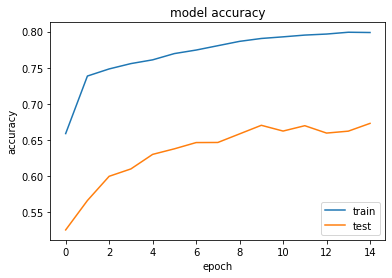

RNN_network Embedding with maximum
Epoch 1/15
476/476 [==============================] - 237s 480ms/step - loss: 0.6717 - binary_accuracy: 0.6533 - val_loss: 0.7999 - val_binary_accuracy: 0.5040
Epoch 2/15
476/476 [==============================] - 226s 474ms/step - loss: 0.5876 - binary_accuracy: 0.7278 - val_loss: 0.8149 - val_binary_accuracy: 0.5040
Epoch 3/15
476/476 [==============================] - 227s 476ms/step - loss: 0.5719 - binary_accuracy: 0.7328 - val_loss: 0.8055 - val_binary_accuracy: 0.5040
Epoch 4/15
476/476 [==============================] - 227s 476ms/step - loss: 0.5641 - binary_accuracy: 0.7342 - val_loss: 0.8048 - val_binary_accuracy: 0.5052
Epoch 5/15
476/476 [==============================] - 226s 475ms/step - loss: 0.5591 - binary_accuracy: 0.7360 - val_loss: 0.8228 - val_binary_accuracy: 0.5087
Epoch 6/15
476/476 [==============================] - 230s 484ms/step - loss: 0.5531 - binary_accuracy: 0.7390 - val_loss: 0.8342 - val_binary_accuracy: 0.5147
Epoch

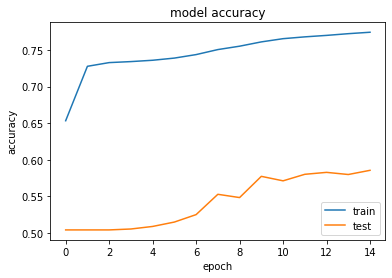

LSTM_network Embedding with concatenate
Epoch 1/15
476/476 [==============================] - 679s 1s/step - loss: 0.6438 - binary_accuracy: 0.6745 - val_loss: 0.6890 - val_binary_accuracy: 0.6025
Epoch 2/15
476/476 [==============================] - 674s 1s/step - loss: 0.5191 - binary_accuracy: 0.7726 - val_loss: 0.6131 - val_binary_accuracy: 0.6660
Epoch 3/15
476/476 [==============================] - 644s 1s/step - loss: 0.4803 - binary_accuracy: 0.7974 - val_loss: 0.5838 - val_binary_accuracy: 0.6914
Epoch 4/15
476/476 [==============================] - 661s 1s/step - loss: 0.4620 - binary_accuracy: 0.8083 - val_loss: 0.5506 - val_binary_accuracy: 0.7045
Epoch 5/15
476/476 [==============================] - 653s 1s/step - loss: 0.4485 - binary_accuracy: 0.8138 - val_loss: 0.5500 - val_binary_accuracy: 0.7048
Epoch 6/15
476/476 [==============================] - 642s 1s/step - loss: 0.4398 - binary_accuracy: 0.8187 - val_loss: 0.5473 - val_binary_accuracy: 0.7133
Epoch 7/15
476/476

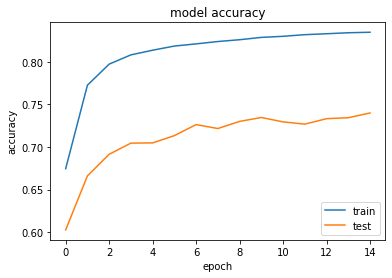

LSTM_network Embedding with maximum
Epoch 1/15
476/476 [==============================] - 664s 1s/step - loss: 0.6540 - binary_accuracy: 0.6573 - val_loss: 0.8008 - val_binary_accuracy: 0.5043
Epoch 2/15
476/476 [==============================] - 645s 1s/step - loss: 0.5661 - binary_accuracy: 0.7353 - val_loss: 0.8290 - val_binary_accuracy: 0.5276
Epoch 3/15
476/476 [==============================] - 646s 1s/step - loss: 0.5227 - binary_accuracy: 0.7672 - val_loss: 0.7671 - val_binary_accuracy: 0.5838
Epoch 4/15
476/476 [==============================] - 646s 1s/step - loss: 0.4943 - binary_accuracy: 0.7864 - val_loss: 0.6933 - val_binary_accuracy: 0.6140
Epoch 5/15
476/476 [==============================] - 645s 1s/step - loss: 0.4772 - binary_accuracy: 0.7964 - val_loss: 0.7576 - val_binary_accuracy: 0.6020
Epoch 6/15
476/476 [==============================] - 646s 1s/step - loss: 0.4646 - binary_accuracy: 0.8040 - val_loss: 0.7431 - val_binary_accuracy: 0.6127
Epoch 7/15
476/476 [==

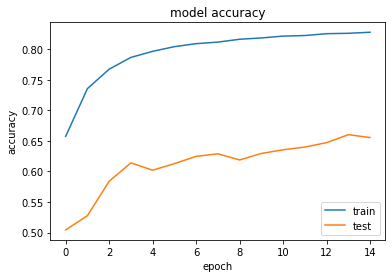

In [11]:
networks = {
            'RNN_network': rnn_network,
            'LSTM_network': lstm_network,
#             'mlp_network': mlp_network,
    
    
}

merging_techniques = ['concatenate', 
#                       'add',
#                       'average',
                      'maximum'
                      ]

y_test = test['Label']

results = []

for network in networks:
    for merging_technique in merging_techniques:
        m = networks[network](max_tokens = tokens,
                              embedding_dimension = emb_dim,
                              embedding_matrix = embedding_matrix,
                              merge_strategy = merging_technique,
                              cos_similarity = True)
        print(f"{network} Embedding with {merging_technique}" )
        network_trained,history = train_network(m)
        plot_metrics(history)
        
        y_pred = np.around(network_trained.predict((test_claim, test_evidence)))
        results.append([network, merging_technique, classification_report(y_test, y_pred, zero_division=True)])
    

In [12]:
'''
Evaluation metrics
'''

for i in range(len(results)):
    print(results[i][0],results[i][1])
    print(results[i][2])

RNN_network concatenate
              precision    recall  f1-score   support

           0       0.84      0.39      0.53      3583
           1       0.61      0.93      0.73      3606

    accuracy                           0.66      7189
   macro avg       0.72      0.66      0.63      7189
weighted avg       0.72      0.66      0.63      7189

RNN_network maximum
              precision    recall  f1-score   support

           0       0.89      0.17      0.29      3583
           1       0.54      0.98      0.70      3606

    accuracy                           0.58      7189
   macro avg       0.71      0.57      0.49      7189
weighted avg       0.71      0.58      0.49      7189

LSTM_network concatenate
              precision    recall  f1-score   support

           0       0.84      0.54      0.66      3583
           1       0.66      0.90      0.76      3606

    accuracy                           0.72      7189
   macro avg       0.75      0.72      0.71      7189
weigh